<a href="https://colab.research.google.com/github/Harshksaw/Machine-Learning/blob/master/stock_market_predML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Live Stock Price Data using Yahoo finance Api

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import math
import matplotlib.pyplot as plt
import tensorflow


In [2]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days = 2000)
d2.strftime("%Y-%m-%d")
start_date = d2


In [3]:
data = yf.download('MSFT' ,start = start_date ,end = end_date, progress = False)

#Importing Data and Ploting 

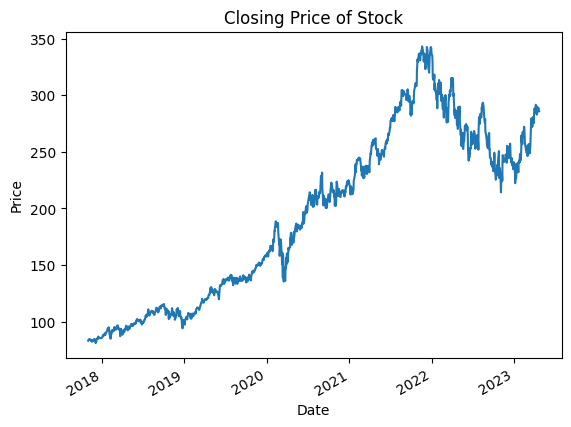

In [4]:
# Set the 'Date' column as the index
# data.set_index('Date', inplace=True)
data['Close'].plot(title='Closing Price of Stock', xlabel='Date', ylabel='Price')
plt.show()

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

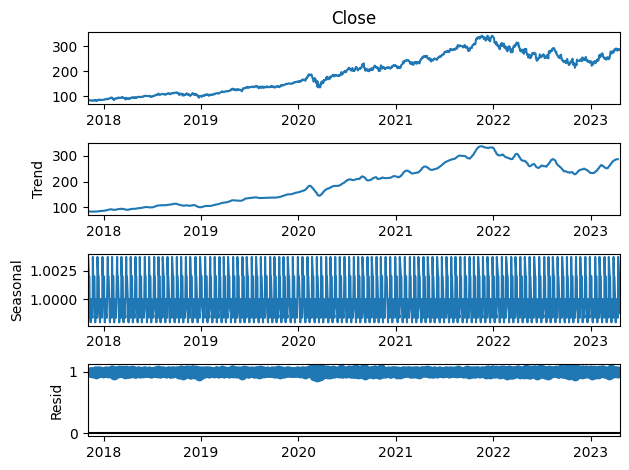

In [6]:
# data.index = data['Date']
results = seasonal_decompose(data['Close'],model = 'multiplicative' , period = 12)
results.plot();

In [7]:
data["Date"] = data.index
data = data[["Date" , "Open" ,"High", "Low","Close","Volume"]]
data.reset_index(drop = True,inplace = True)

In [8]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-01,83.680000,83.760002,82.879997,83.180000,22307400
1,2017-11-02,83.349998,84.459999,83.120003,84.050003,23992900
2,2017-11-03,84.080002,84.540001,83.400002,84.139999,17633500
3,2017-11-06,84.199997,84.699997,84.080002,84.470001,19860900
4,2017-11-07,84.769997,84.900002,83.930000,84.269997,17939700


Seasonal decomposition is a technique used to break down a time series into its trend, seasonal, and residual
-> If the magnitude of the seasonal component changes with time, then the series is multiplicative. so we have taken multiplicative here -> Multiplicative: x t = Trend * Seasonal * Random

In [9]:
data.shape

(1376, 6)

In [10]:
data['Close']

0        83.180000
1        84.050003
2        84.139999
3        84.470001
4        84.269997
           ...    
1371    288.799988
1372    288.369995
1373    288.450012
1374    286.109985
1375    285.760010
Name: Close, Length: 1376, dtype: float64

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

Making moving average ma100 -> moving average 100 ma50 -> moving average 50


In [12]:
ma100 = data.Close.rolling(100).mean()
ma50 = data.Close.rolling(50).mean()
ma200 = data.Close.rolling(200).mean()

Observation -> When the moving average of 50 periods crosses above the moving average of 100 periods, it is often seen as a bullish signal in technical analysis. Conversely, when the 50-period moving average crosses below the 100-period moving average, it is often seen as a bearish signal.
-> Looking at bigger picture When a long-term moving average, such as the 200-day moving average, crosses above or below a short-term moving average, such as the 100-day moving average, it is known as a "moving average crossover." This is a common technical analysis signal used by traders and investors to identify potential changes in trend

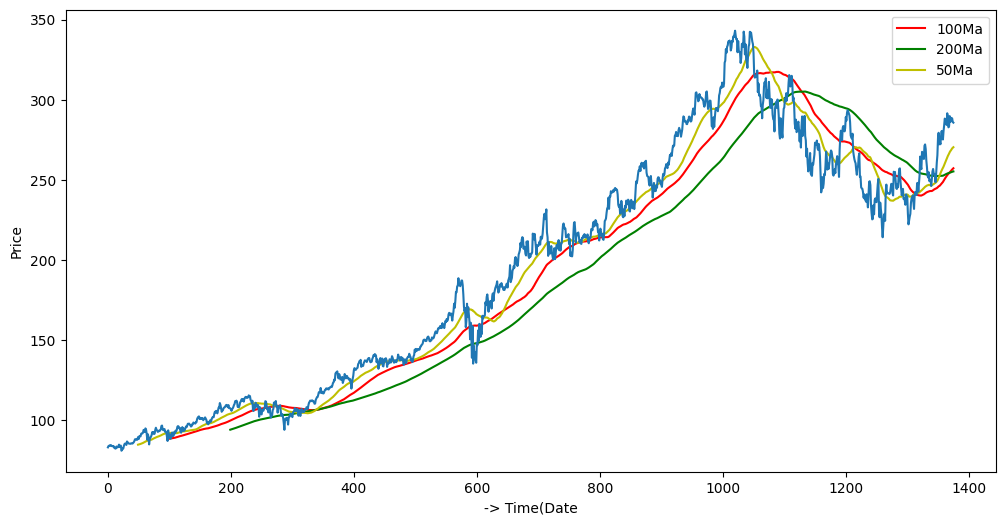

In [13]:
plt.figure(figsize = (12,6)) 
plt.plot(ma100,color ='r', label ="100Ma")
plt.plot(ma200,color ='g', label ="200Ma")
plt.plot(ma50,color ='y' ,label ="50Ma")
plt.xlabel("-> Time(Date")
plt.ylabel("Price")
plt.legend()
plt.plot(data.Close)

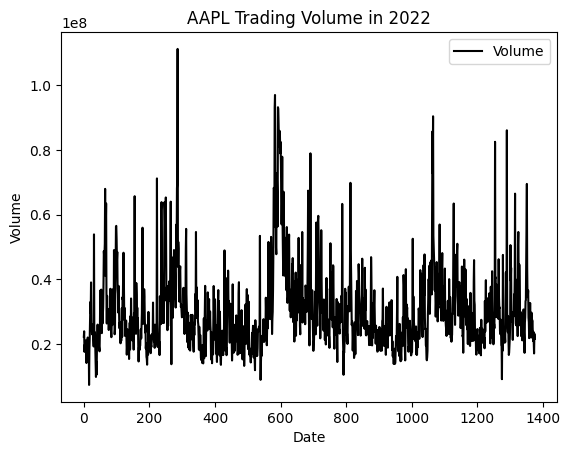

In [14]:
data['Volume'].plot(style='k-', title='AAPL Trading Volume in 2022', xlabel='Date', ylabel='Volume') 
plt.legend()

In [15]:
df =data
df.head()

,Date,Open,High,Low,Close,Volume
0,2017-11-01,83.680000,83.760002,82.879997,83.180000,22307400
1,2017-11-02,83.349998,84.459999,83.120003,84.050003,23992900
2,2017-11-03,84.080002,84.540001,83.400002,84.139999,17633500
3,2017-11-06,84.199997,84.699997,84.080002,84.470001,19860900
4,2017-11-07,84.769997,84.900002,83.930000,84.269997,17939700


In [16]:
df = df.reset_index()['Close']
df.shape

(1376,)

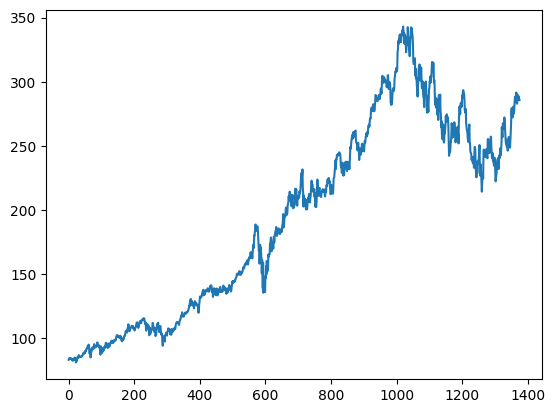

In [17]:
plt.plot(df) #data set we will work with for training 

LSTM model are sensitive to scale of the data. so we apply MinMaxScaler


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [19]:
df


array([[0.00801434],
       [0.01133459],
       [0.01167804],
       ...,
       [0.79139802],
       [0.78246764],
       [0.78113201]])

Splitting the data into train and test split

In [20]:
training_size = int(len(df)* 0.75)
test_size = len(df) - training_size

train_data , test_data = df[0: training_size], df[training_size : len(df),  :1]

In [21]:
len(train_data), len(test_data)

(1032, 344)

In [22]:
#create an array of values into a dataset matrix
# function ->

def dataset_reshape(dataset , time_steps = 1):
  dataX , dataY = [],[]
  for i in range(len(dataset)-time_steps -1):
    a = dataset[i : (i + time_steps) , 0]  # 1 ,2 ,3 -- 100  , append(101)
    dataX.append(a)
    dataY.append(dataset[i + time_steps, 0])
  return np.array(dataX), np.array(dataY)

In [23]:
time_steps = 100
X_train , y_train = dataset_reshape(train_data , time_steps )
X_test , y_test = dataset_reshape(test_data , time_steps)

In [24]:
print(X_train.shape)

(931, 100)


In [25]:
#convert in into 3D dimensional 
# [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [26]:
# X_train[2]

MODEL ->

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM

In [120]:
model = Sequential()
model.add(LSTM(50 , return_sequences = True, input_shape = (100, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [121]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

MODEL TRAINING ->

In [ ]:
model.fit(X_train,y_train,batch_size =1,epochs = 1)

931/931 [==============================] - 53s 53ms/step - loss: 0.0099


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
train_predict.shape
test_predict.shape

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))


In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan

# . Then, np.nan is used to set all the elements of trainPredictPlot and testPredictPlot to NaN, which creates a blank plot.

trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

# train_predict and test_predict are arrays containing the predicted values from the model's training and testing sets, respectively. 
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot , label = 'training_data' ,)
plt.plot(testPredictPlot, label = 'testing_data')
plt.legend()
plt.show()

**PREDDICTING FUTURE 30 days


In [ ]:
len(test_data)

In [ ]:
x_input = test_data[44 : ].reshape(1,-1)
x_input.shape

In [ ]:
temp_input = list(x_input) #converting it into list
temp_input = temp_input[0].tolist()


In [ ]:
temp_input

In [ ]:
diff = np.diff(temp_input)
print(diff.sum())

LOGIC for prediction of next -> days

In [ ]:
list_output = []
n_steps = 300  #->Timesteps
i = 0
while(i<60):

  if(len(temp_input) > 300):
    #printing the temp input
    x_input = np.array(temp_input[1:])
    print("{} day input ->{} ".format(i,x_input))
    x_input = x_input.reshape(1 , -1)
    x_input = x_input.reshape((1, n_steps , 1))
    yhat  = model.predict(x_input , verbose = 0)
    print("{} day output -> {}".format(i,yhat))
    # yhat is a variable that holds the output of the model's prediction.
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    list_output.extend(yhat.tolist())
    i = i+ 1

  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose = 0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    # Overall, this line of code is adding the predicted value(s) from the model to temp_input,
    #  which is presumably being used as input for the model's next prediction.
    print(len(temp_input))
    list_output.extend(yhat.tolist())
    i = i+1

# print(list_output)

In [ ]:
print(list_output) 
#predicted 60 days values -> 

In [ ]:
day_new = np.arange(1,301)
day_pred = np.arange(301,361)

In [ ]:
len(df)

In [ ]:
df2 = df.tolist()

In [ ]:
# plotting from previous 100 days so ->

start_date = len(df) -300
start_date

In [ ]:
plt.plot(day_new , scaler.inverse_transform(df[start_date :])) #ploting the graph from dataset we had trained our model on
plt.plot(day_pred ,scaler.inverse_transform(list_output))  #Out predicted next 30 days data , predicted from the model we trained out datset


In [ ]:
df2 = df.tolist()
df2.extend(list_output)
plt.plot(df2[1000:])